In [11]:
#load the modules
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
import pandas as pd
import shapely.geometry as geometry
import random
import matplotlib.pylab as plt
import os

In [12]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
        # already added
            return edges.add( (i, j) )
        edge_points.append(coords[[i, j]])
    
    coords = np.array([point for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [13]:
from descartes import PolygonPatch
def plot_polygon(polygon,margin_x = 100, margin_y = 50):
    '''
    input the polygon and margin output the polygon circle the points in th
    '''
    fig, ax = plt.subplots(figsize=(10,10))
    margin_x = margin_x
    margin_y = margin_y
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin_x, x_max+margin_x])
    ax.set_ylim([y_min-margin_y, y_max+margin_y])
    patch = PolygonPatch(polygon, fc='#f6d55c',
                         ec='grey', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

In [14]:
file_path = 'F:/emb_data/v11/Alclat2_stem/true_tif_has_fn_no_fp'
points = pd.read_csv(os.path.join(file_path,'emb_points_time.csv'), sep=",",index_col= 0)#sep=';' when using get_data.Rmd

In [15]:
print(points.head())
sample_point_Z = points.loc[points.number_emb == 15,]#look at the 15th embolism event

     row    col  number_emb  cc_num_emb  cc_width  cc_height  cc_area  \
0  209.0  419.0           1         1.0       7.0       16.0     55.0   
1  210.0  419.0           1         1.0       7.0       16.0     55.0   
2  211.0  417.0           1         1.0       7.0       16.0     55.0   
3  211.0  418.0           1         1.0       7.0       16.0     55.0   
4  211.0  419.0           1         1.0       7.0       16.0     55.0   

   cc_centroid_row  cc_centroid_col        embolism_time  \
0       217.290909       420.036364  2019-07-25 15:01:45   
1       217.290909       420.036364  2019-07-25 15:01:45   
2       217.290909       420.036364  2019-07-25 15:01:45   
3       217.290909       420.036364  2019-07-25 15:01:45   
4       217.290909       420.036364  2019-07-25 15:01:45   

   time_since_start(mins)  
0                     262  
1                     262  
2                     262  
3                     262  
4                     262  


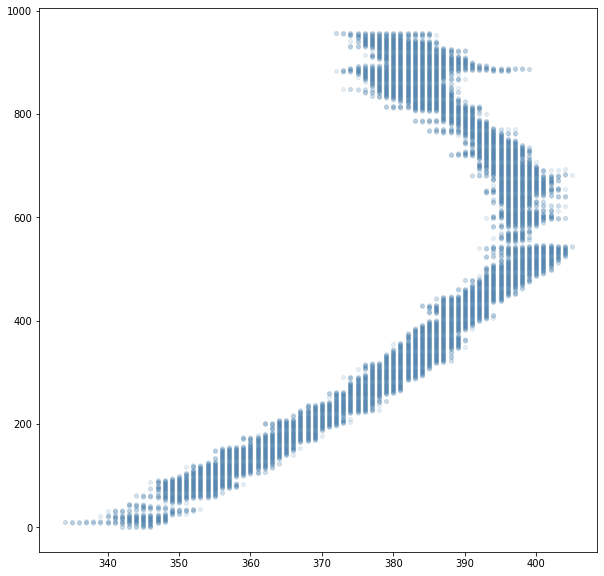

In [16]:
#lets see how points look like 
plt.figure(figsize=(10,10))
_ = plt.plot(sample_point_Z.col, sample_point_Z.row,'o',color='#20639B',alpha = 0.1, markersize = 4)

In [17]:
row_col_idx = int(np.where(sample_point_Z.columns == 'row')[0])#get the column index that has column names 'row'
col_col_idx = int(np.where(sample_point_Z.columns == 'col')[0])
#print(row_col_idx,col_col_idx)
points_list = [list(sample_point_Z.iloc[i,row_col_idx:(col_col_idx+1)]) for i in range(len(sample_point_Z))]
x = [p[0] for p in points_list]
y = [p[1] for p in points_list]

# Need to take a look at this envelope

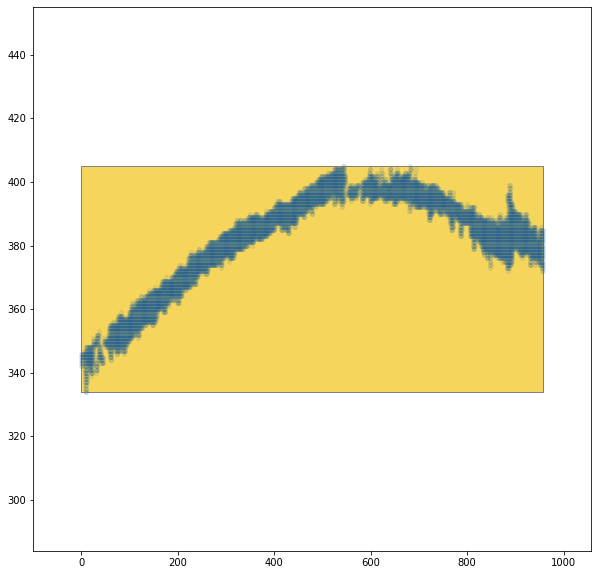

In [18]:
point_collection = geometry.MultiPoint(points_list)
_ = plot_polygon(point_collection.envelope)
_ = plt.plot(x,y,'o', color='#20639B',markersize = 4,alpha = 0.1)

# Boundaries is not supposed to be so uniform and straight, so we will naturally led to experiment with the CONVEX HULL of the points.

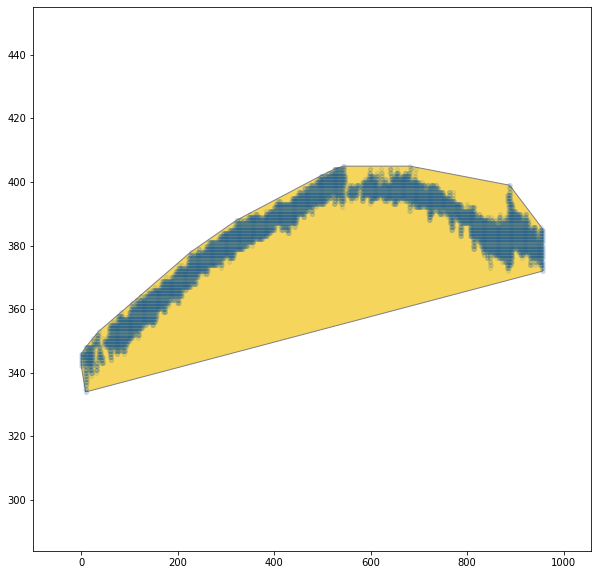

In [19]:
convex_hull_polygon = point_collection.convex_hull
_ = plot_polygon(convex_hull_polygon)
_ = plt.plot(x,y,'o', color='#20639B',markersize = 4,alpha = 0.1)

In [20]:
sam_points_list = random.sample(points_list,math.floor(0.1*len(points_list)))

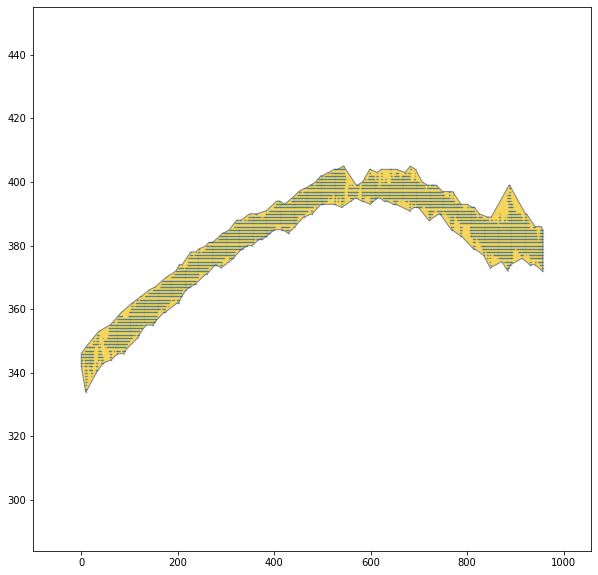

In [21]:
concave_hull, edge_points = alpha_shape(points_list, alpha=0.018)
_ = plot_polygon(concave_hull)
_ = plt.plot(x,y,'o', color='#20639B',markersize = 0.5,alpha = 0.4)

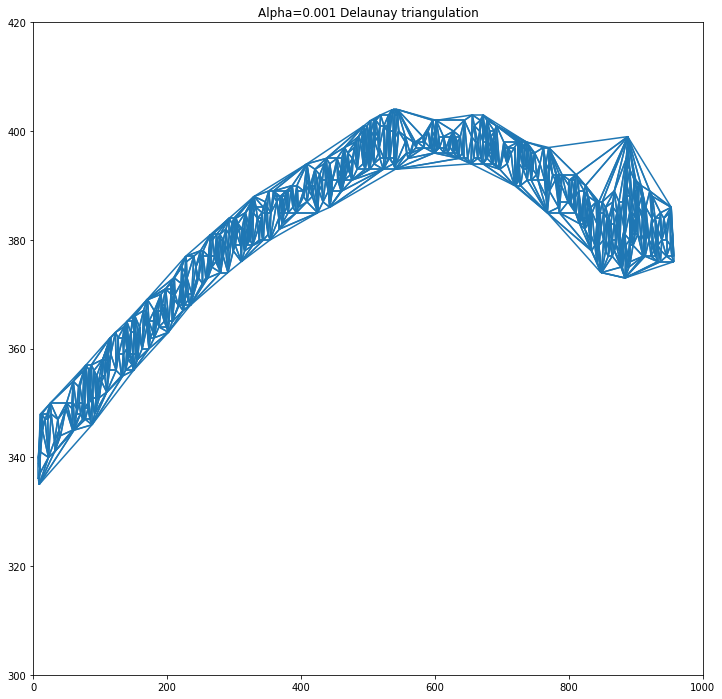

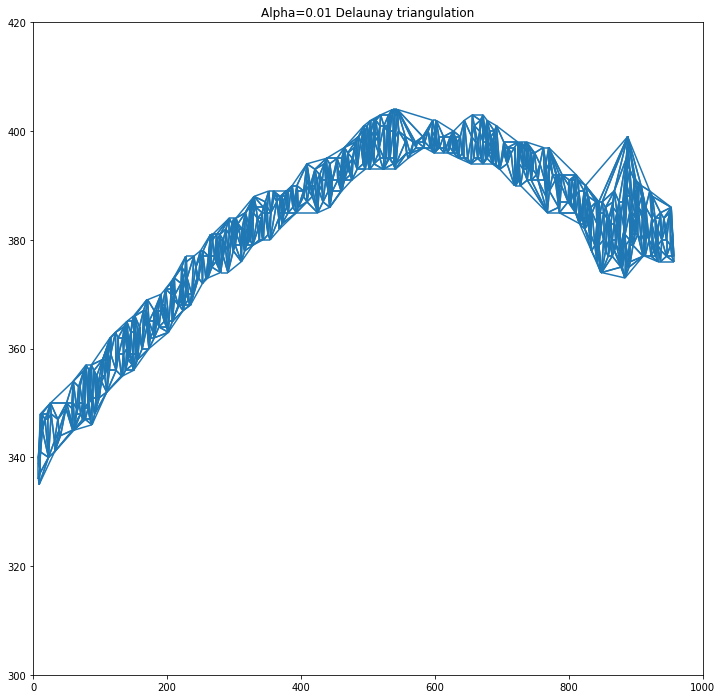

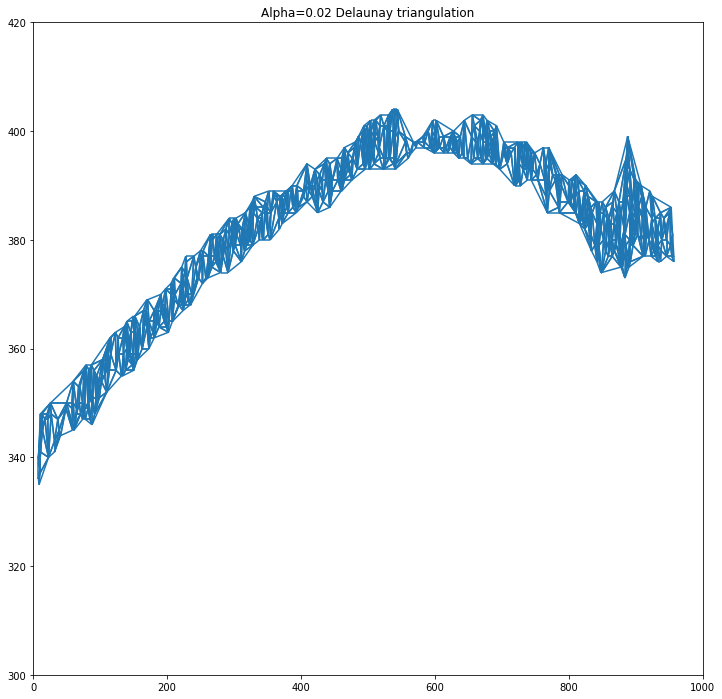

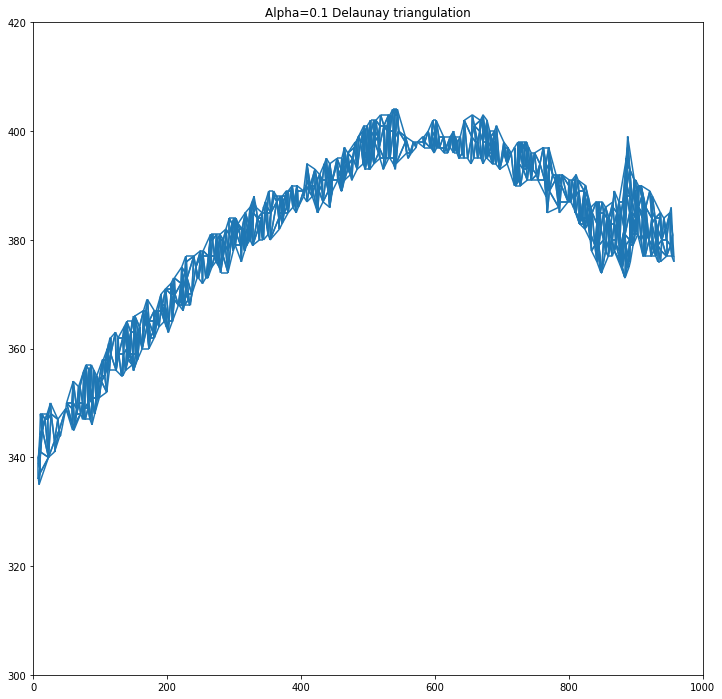

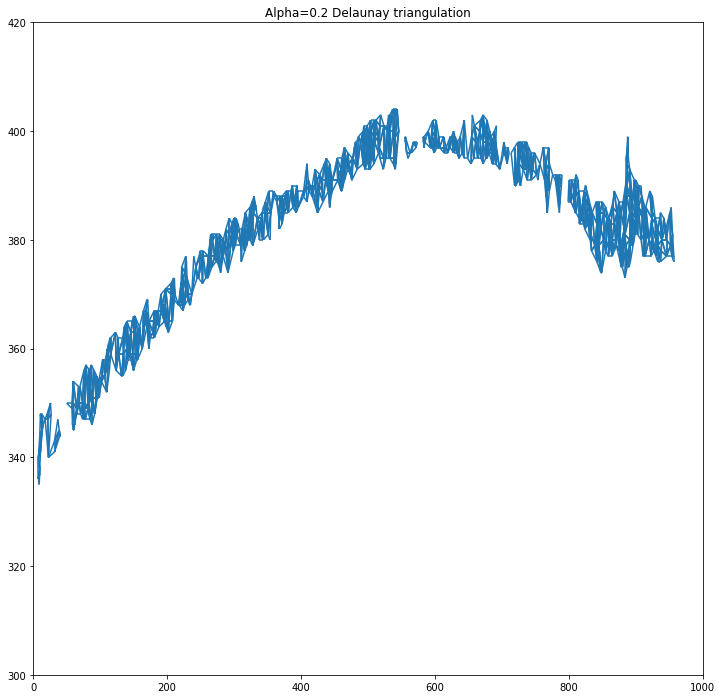

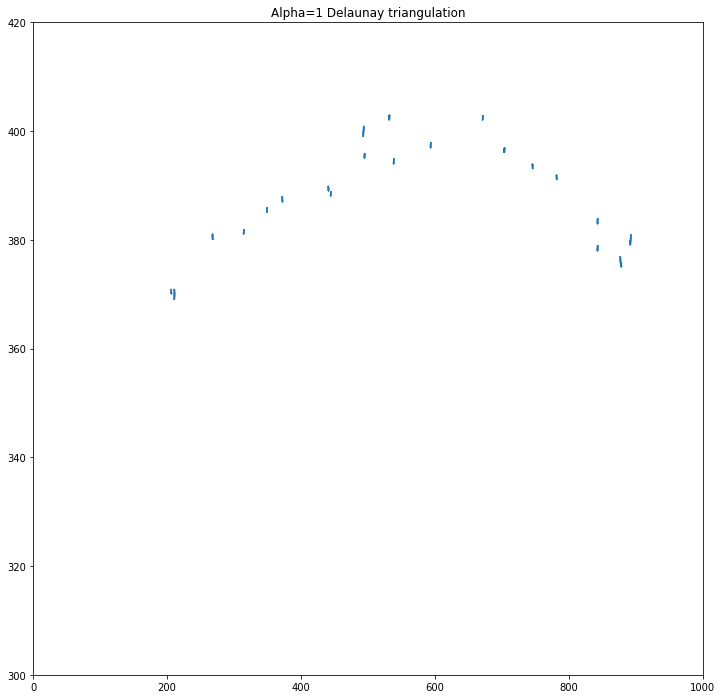

In [22]:
from matplotlib.collections import LineCollection
alpha_list = [0.001,0.01,0.02,0.1,0.2,1]
for i in alpha_list:
    concave_hull, edge_points = alpha_shape(sam_points_list, alpha=i)
    lines_to_plot = LineCollection(edge_points)
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xlim(0, 1000)
    ax.set_ylim(300, 420)
    ax.set_title('Alpha={0} Delaunay triangulation'.format(i))
    ax.add_collection(lines_to_plot)
    plt.show()

In [23]:
#subset the embolism that less than 400 pixels too less
from collections import Counter
embolism_list = []
for i in np.unique(points.number_emb):
    table_z = Counter(points.number_emb)
    if table_z[i] > 500:
        embolism_list.append(i)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


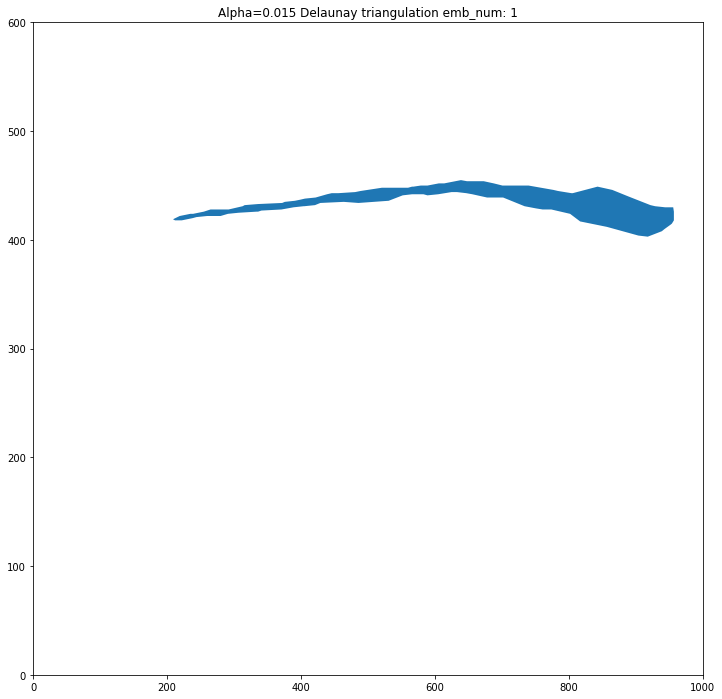

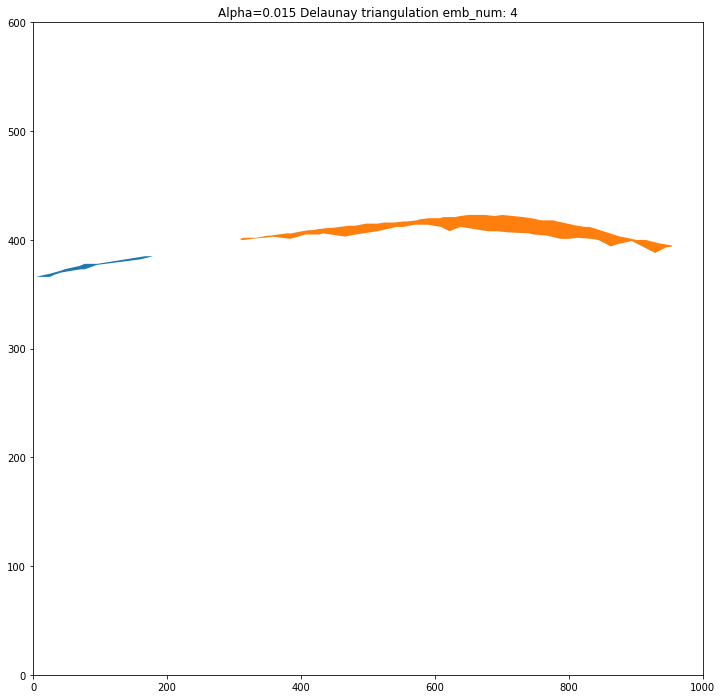

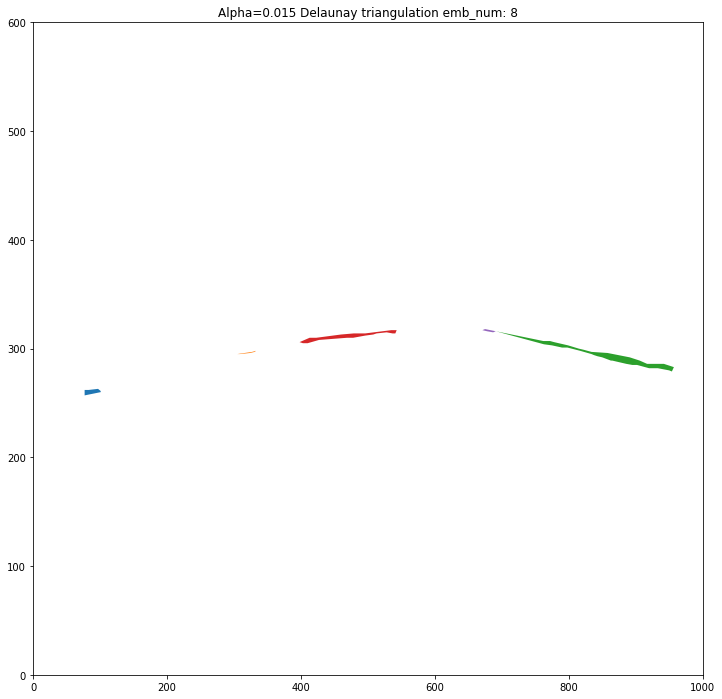

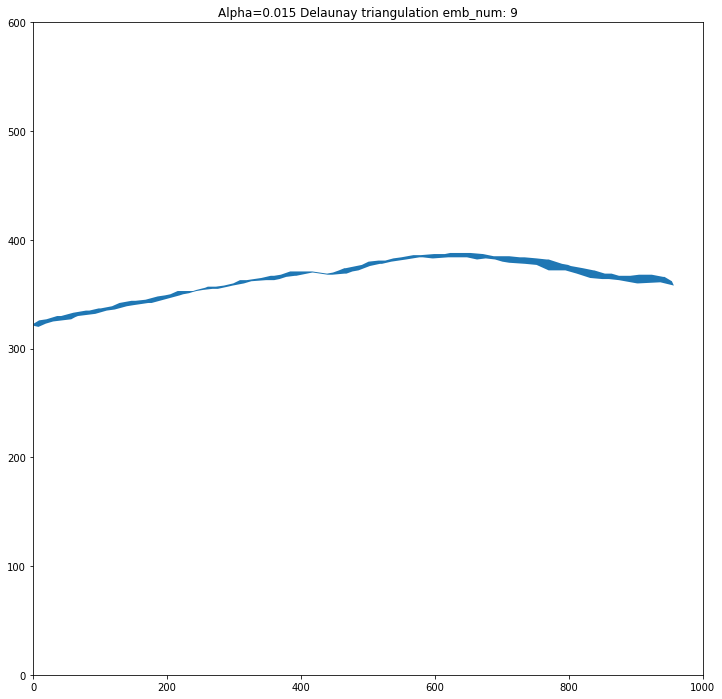

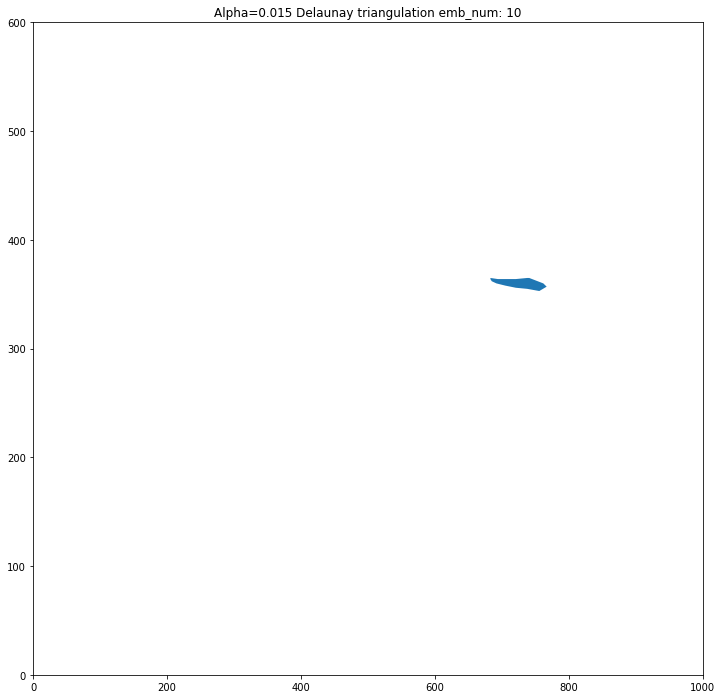

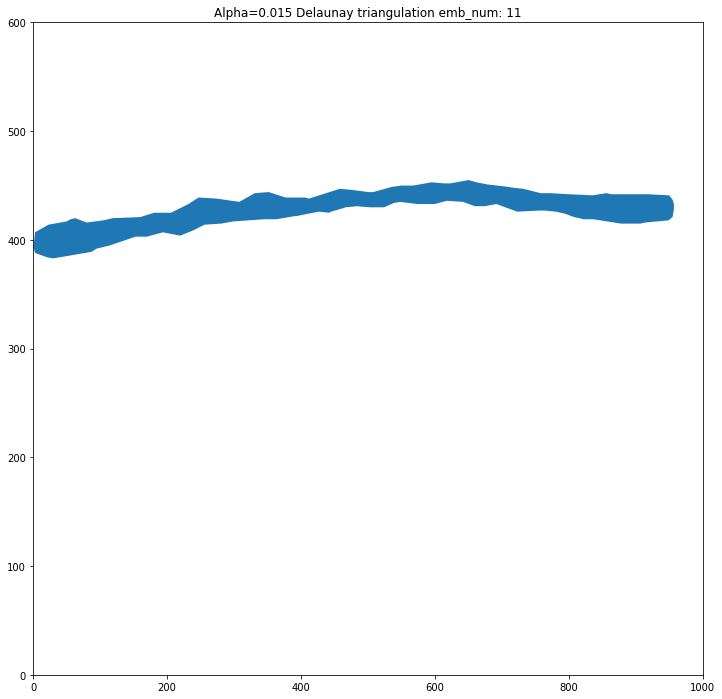

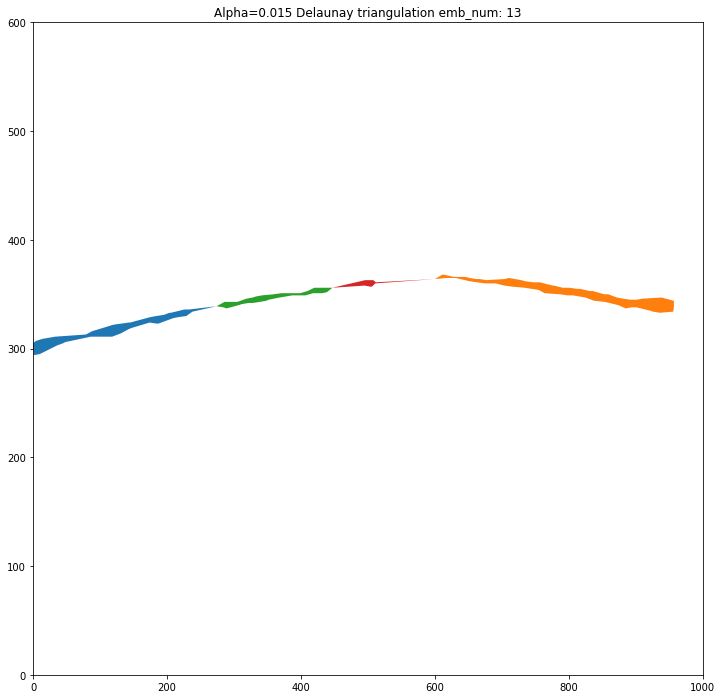

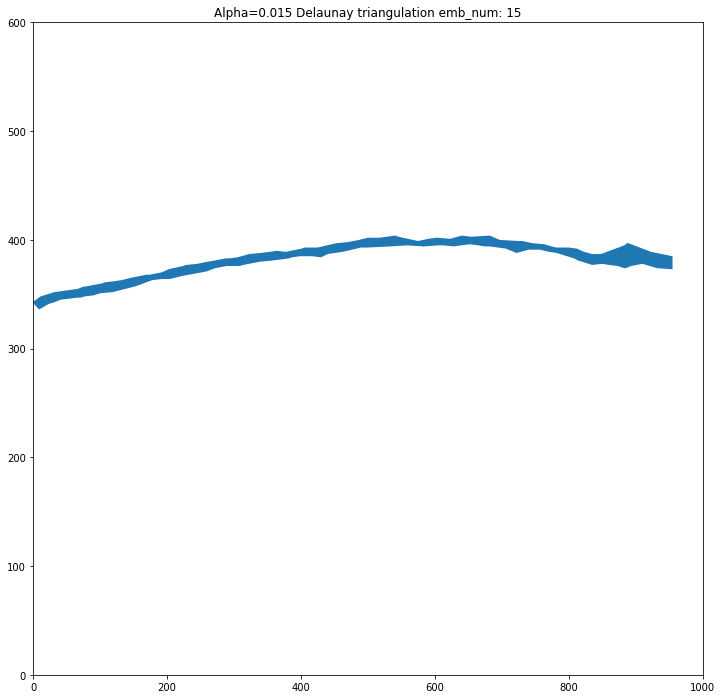

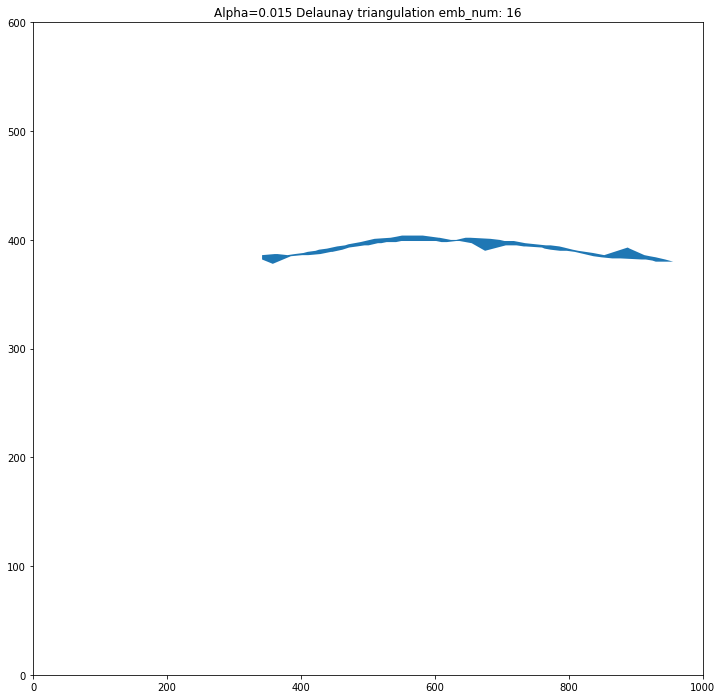

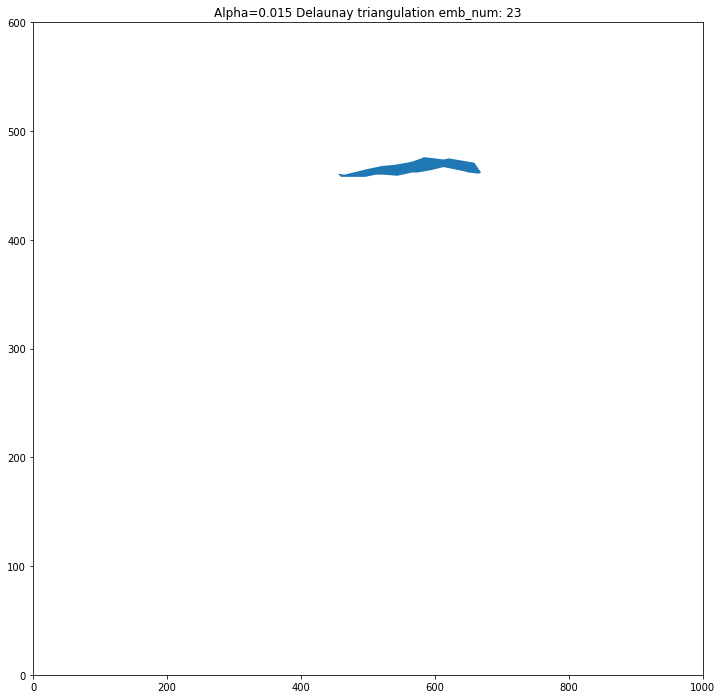

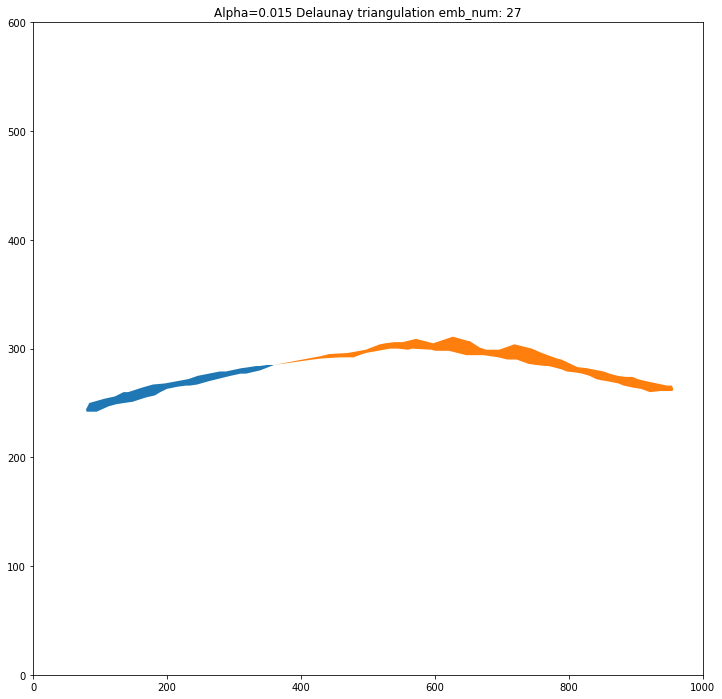

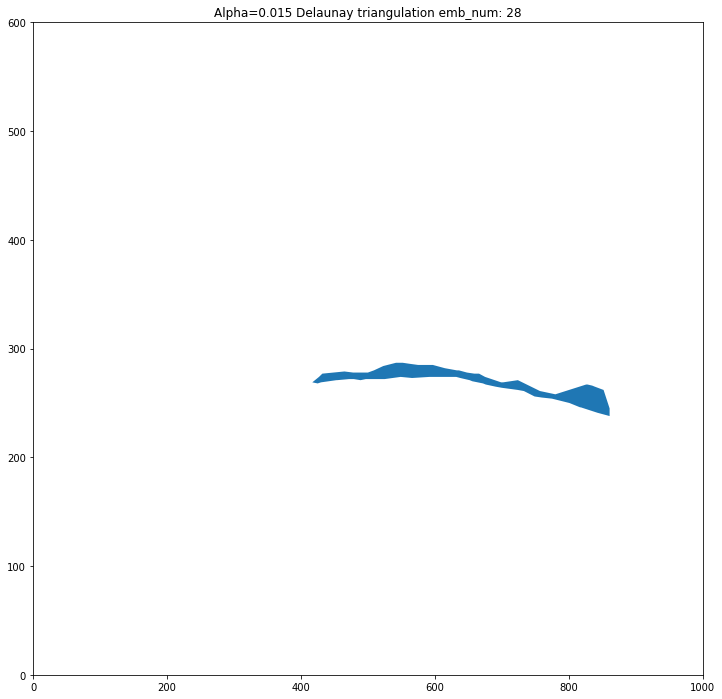

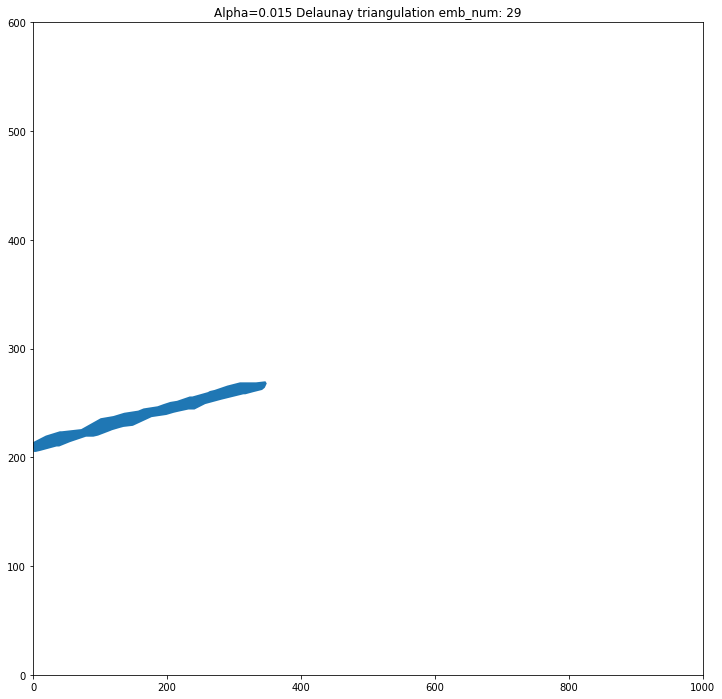

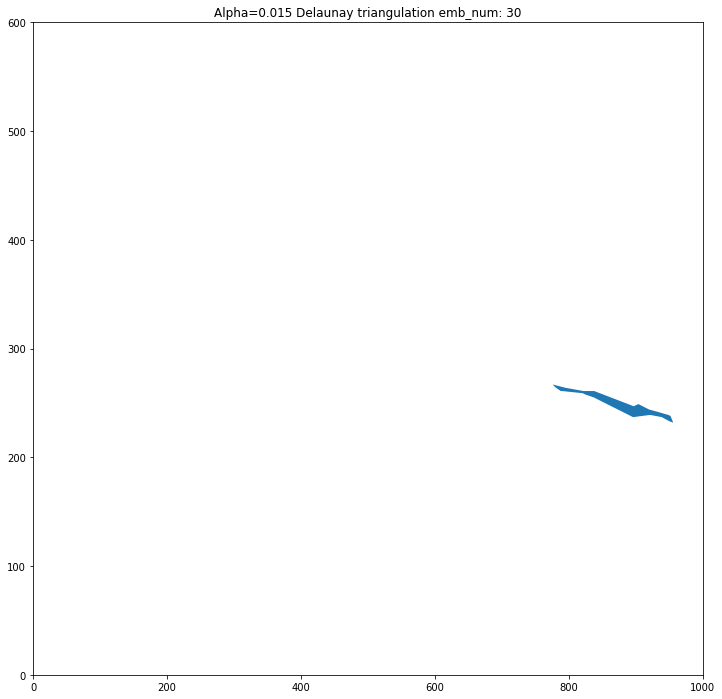

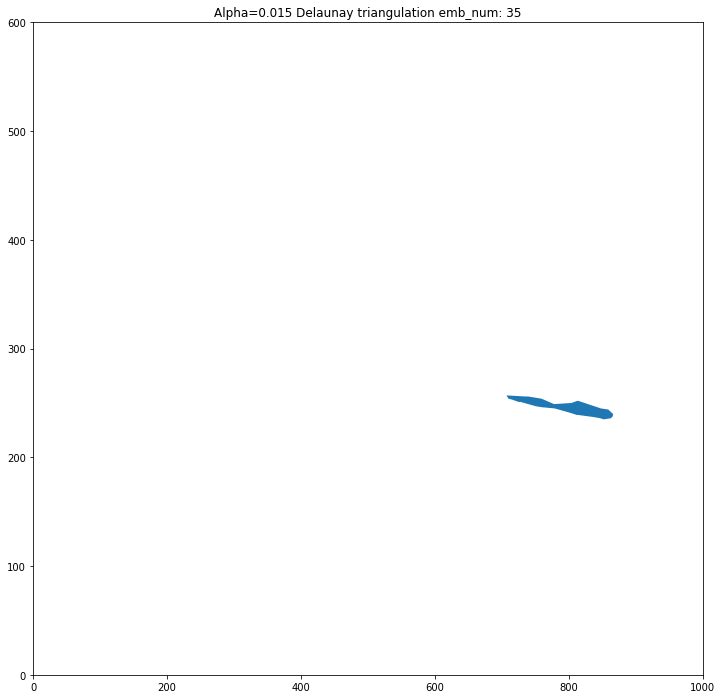

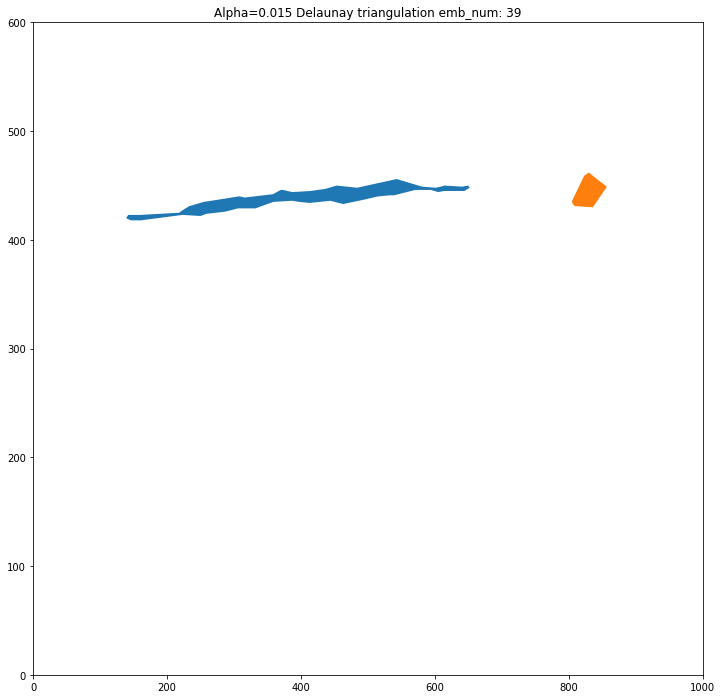

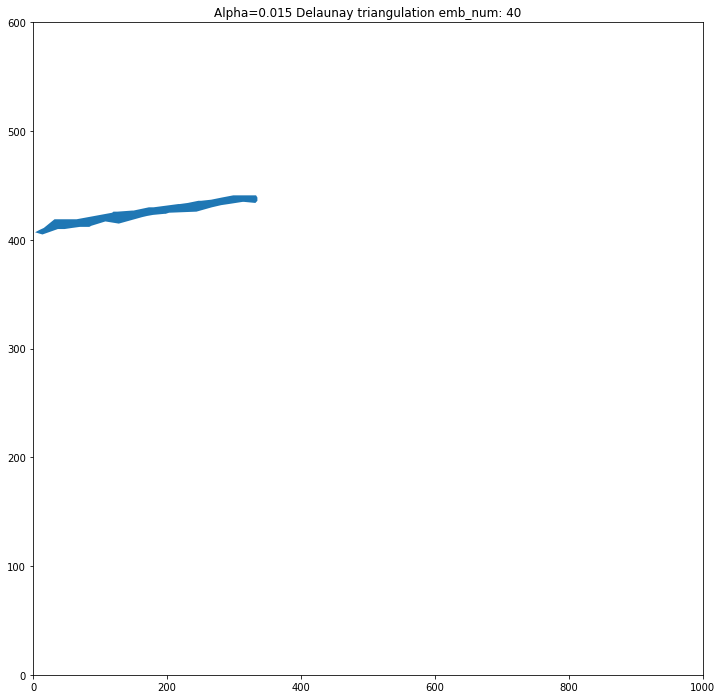

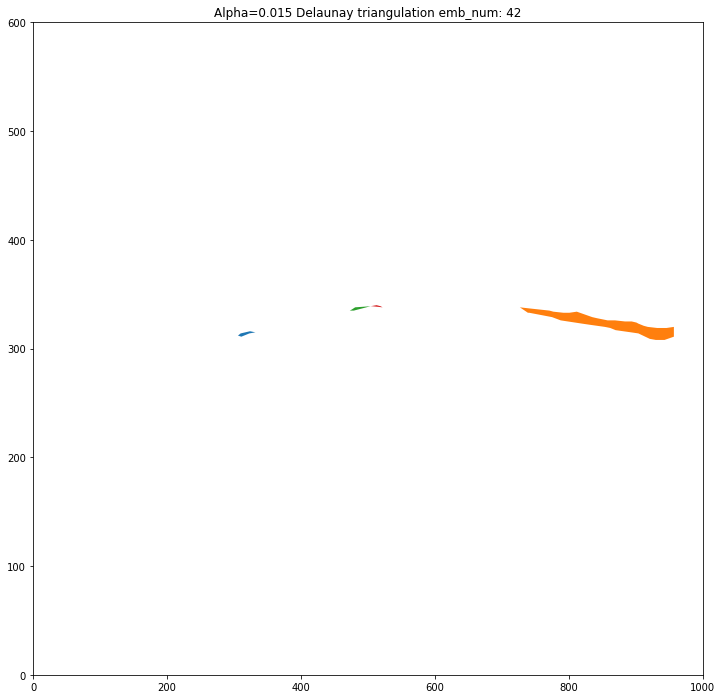

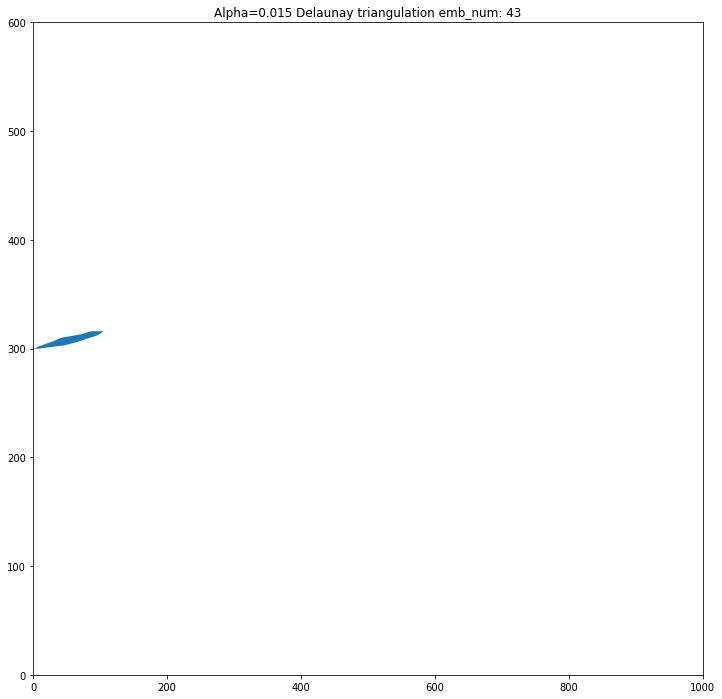

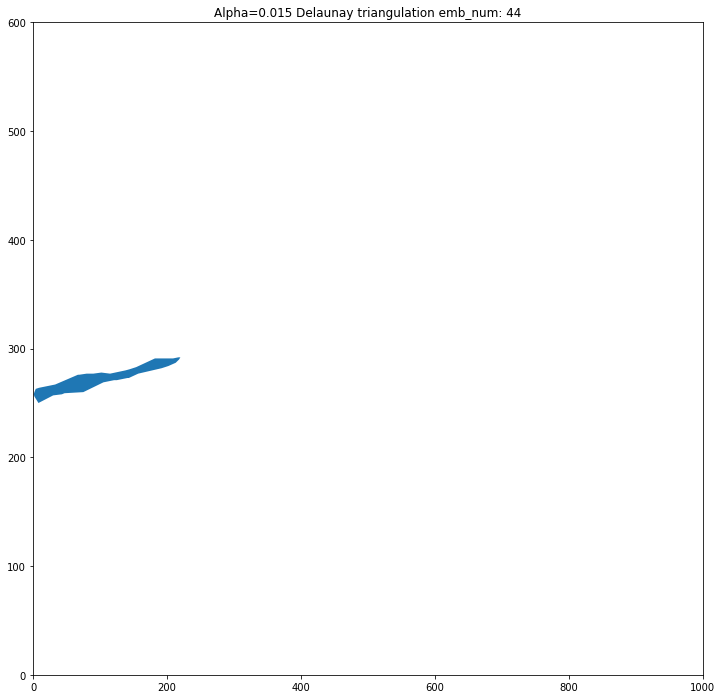

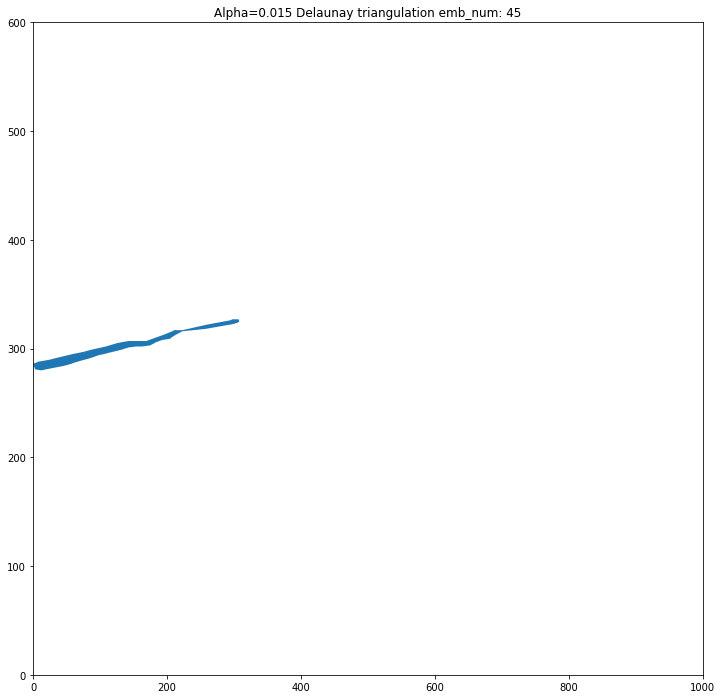

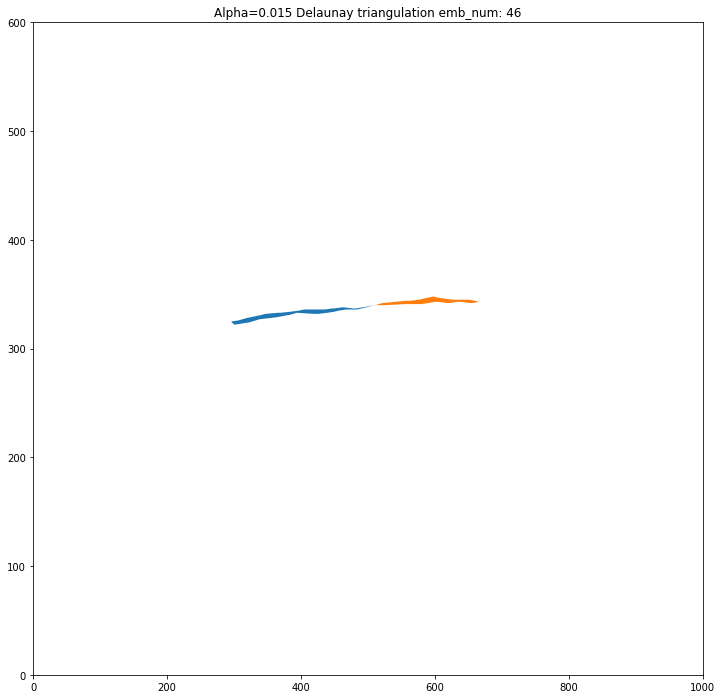

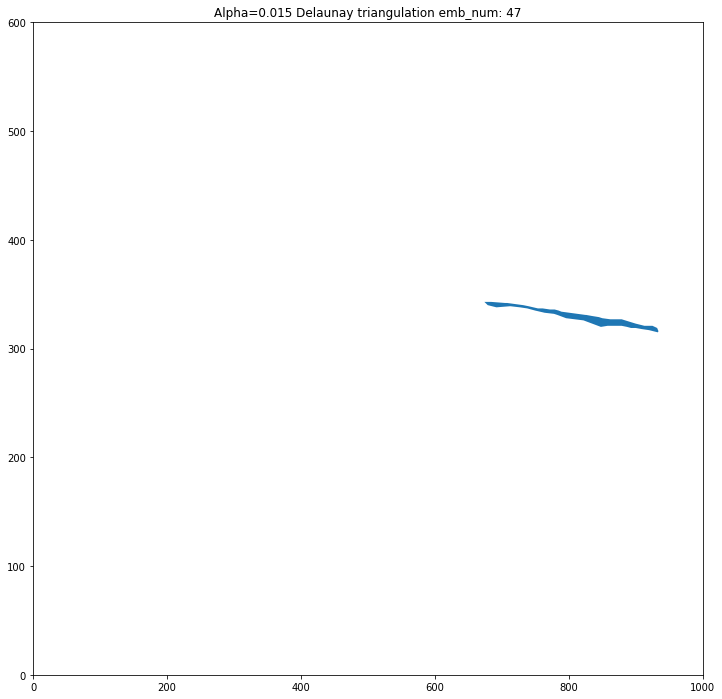

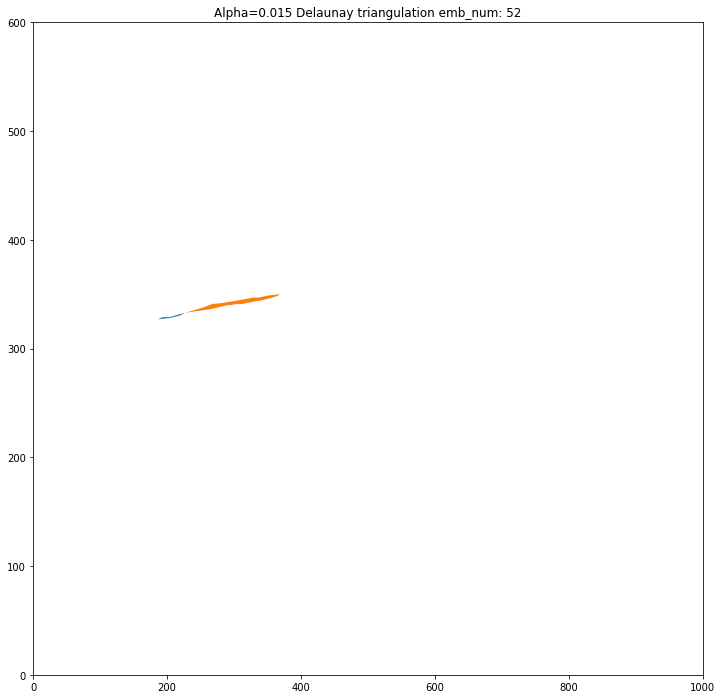

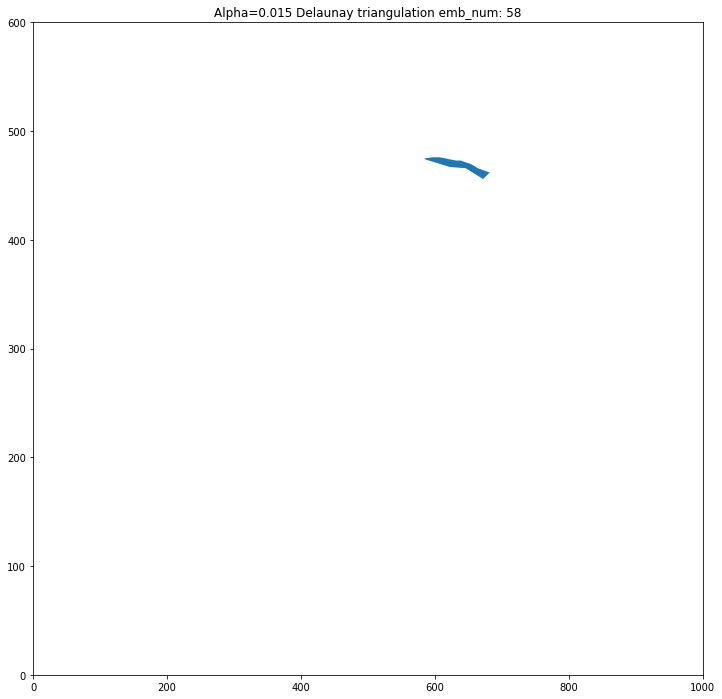

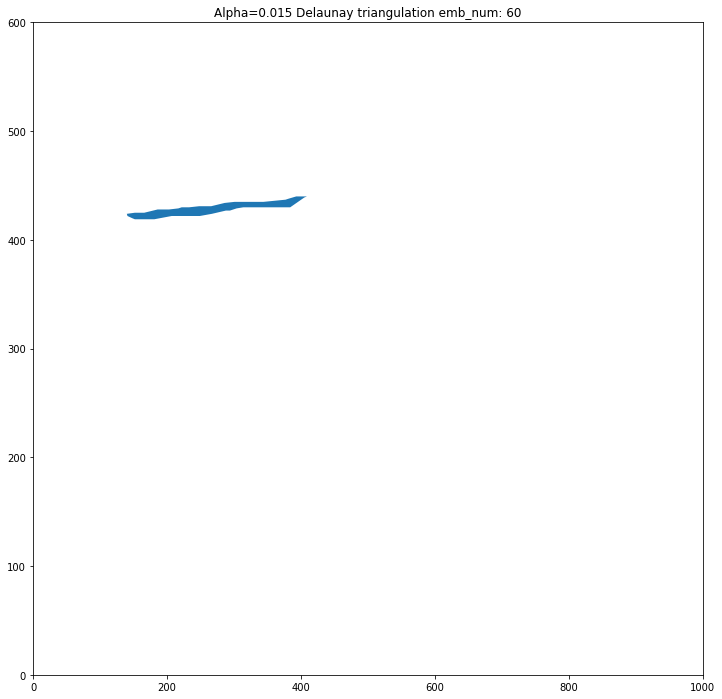

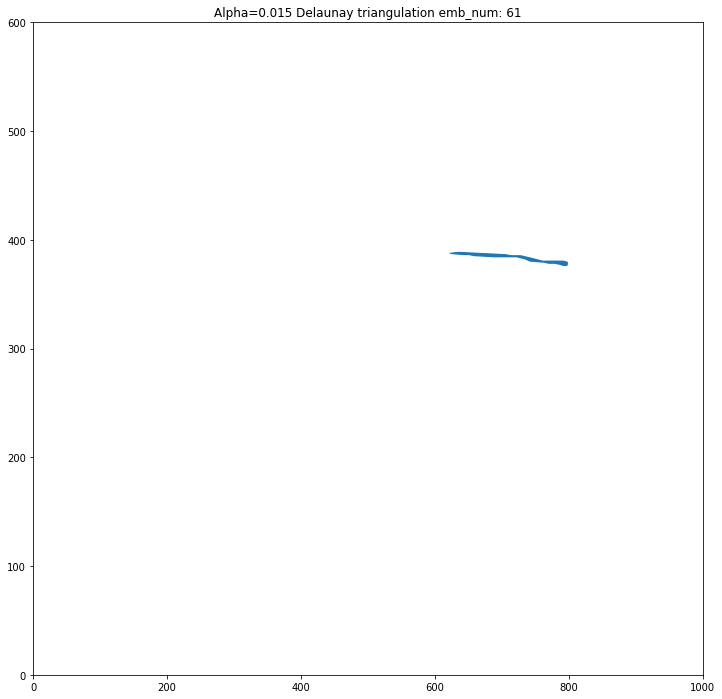

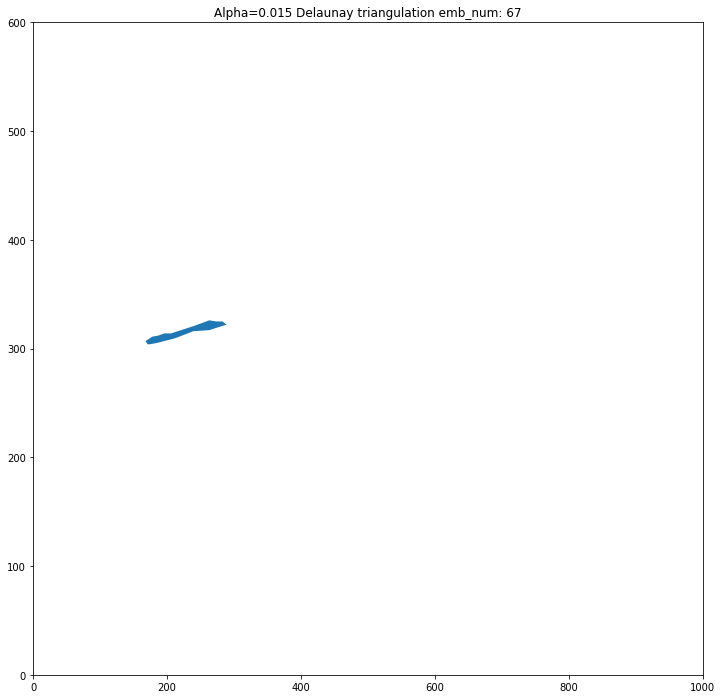

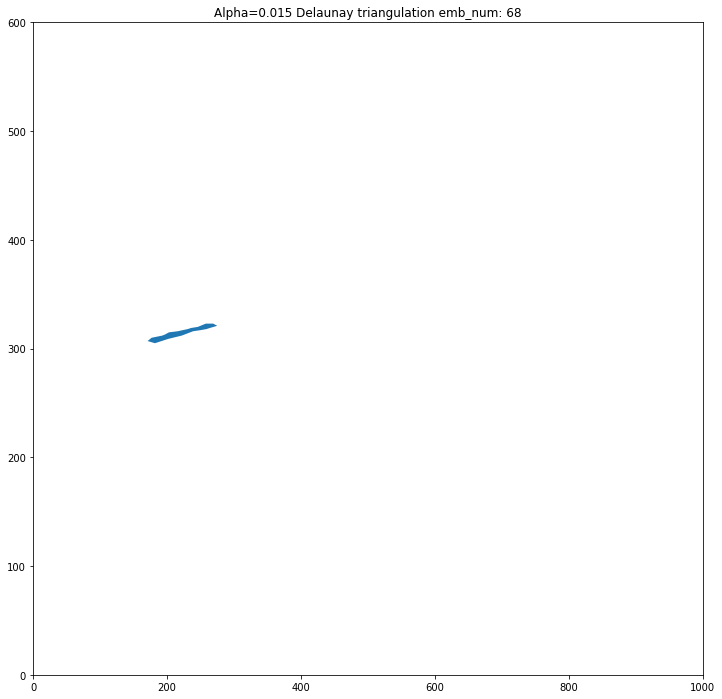

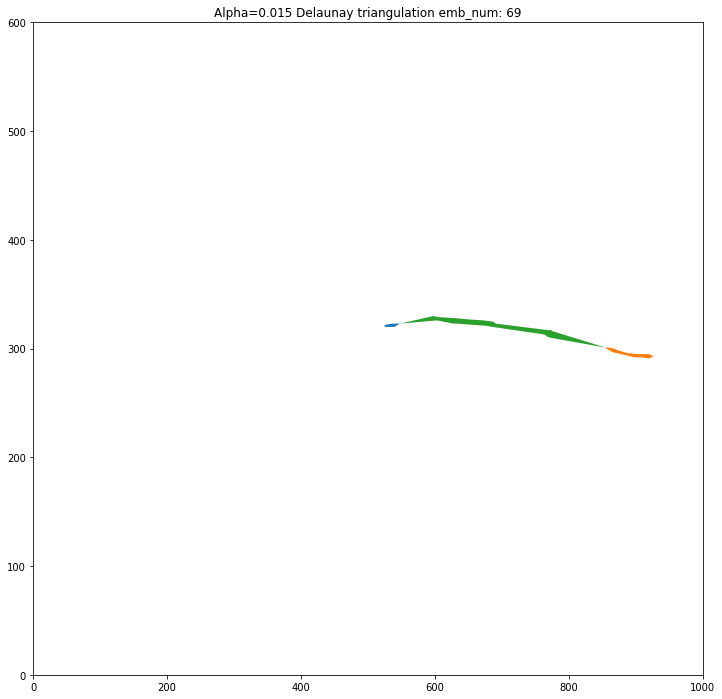

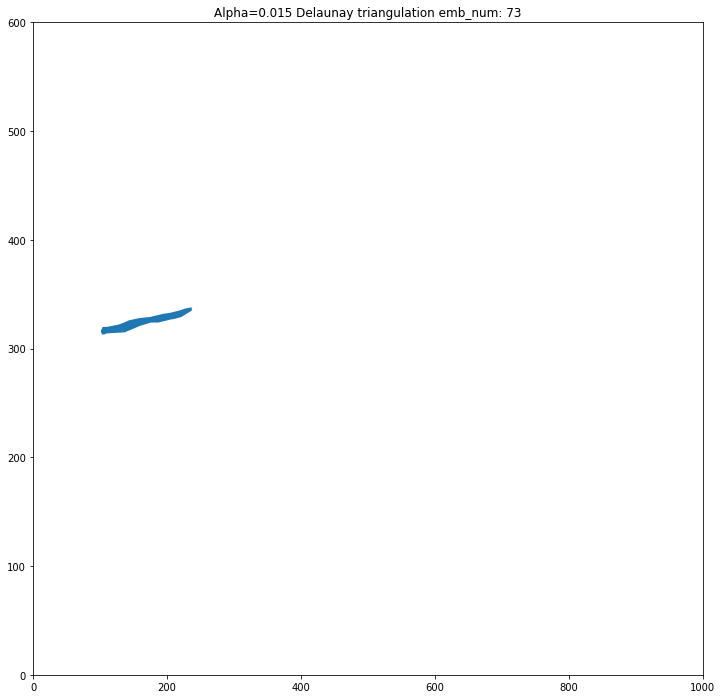

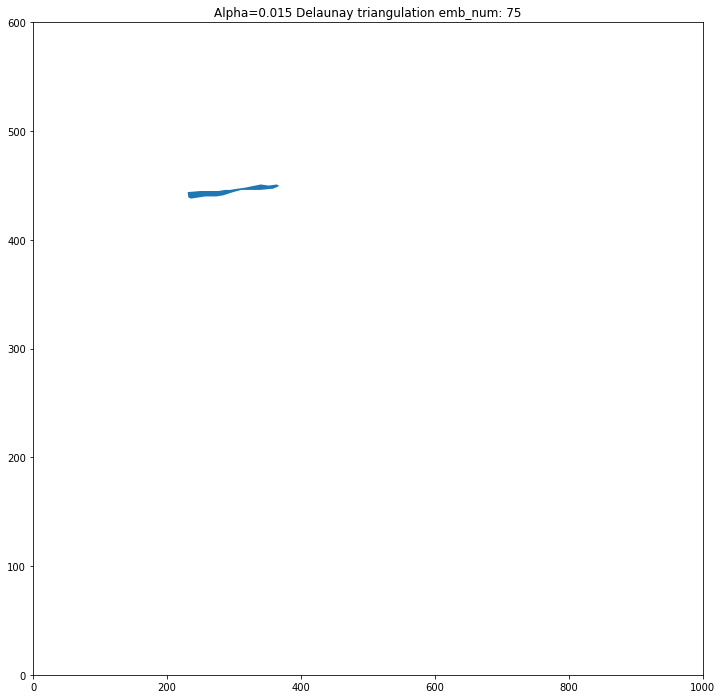

In [24]:
polygon_vertices = np.array([[0,0,0]]) #vertices matrix for plot
for emb_num in embolism_list:
    sample_point_Z = points.loc[points.number_emb == emb_num,]
    points_list = [list(sample_point_Z.iloc[j,row_col_idx:(col_col_idx+1)]) for j in range(len(sample_point_Z))]
    x = [p[0] for p in points_list]
    y = [p[1] for p in points_list]
    # might need to decide the alpha value acccording to the length of 
    alpha = 0.015
    #might need to decide if the points too small 
    sam_points_list = random.sample(points_list,math.floor(0.1*len(points_list)))
    concave_hull, edge_points = alpha_shape(sam_points_list, alpha = alpha)
    #if we have 2 concave, we only want to visualize the first
    if concave_hull.geom_type == 'Polygon':
        vertices = np.transpose(np.array([concave_hull.exterior.xy[0], # x axis 
                                  concave_hull.exterior.xy[1], # y axis
                                  np.repeat(emb_num,len(concave_hull.exterior.xy[0]))])) #put the label
        polygon_vertices = np.concatenate((polygon_vertices,vertices), axis = 0)
        fig, ax = plt.subplots(figsize = (12,12))
        ax.fill(concave_hull.exterior.xy[0], concave_hull.exterior.xy[1])
        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 600)
        ax.set_title('Alpha={0} Delaunay triangulation'.format(alpha) + ' emb_num: ' + str(emb_num))
    else:
        fig, ax = plt.subplots(figsize = (12,12))
        num_polygon = len(concave_hull)
        for num in range(num_polygon):
            #put the vertices data in for each polygon
            vertices = np.transpose(np.array([concave_hull[num].exterior.xy[0], # x axis 
                                  concave_hull[num].exterior.xy[1], # y axis
                                  np.repeat(emb_num,len(concave_hull[num].exterior.xy[0]))])) #put the label
            polygon_vertices = np.concatenate((polygon_vertices,vertices), axis = 0)
            #plot the concave hull for different ploygon
            ax.fill(concave_hull[num].exterior.xy[0], concave_hull[num].exterior.xy[1])
        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 600)
        ax.set_title('Alpha={0} Delaunay triangulation'.format(alpha) + ' emb_num: ' + str(emb_num))

In [25]:
#clean up the zero values
polygon_vertices = np.delete(polygon_vertices,(0), axis = 0)
#put into csv file
polygon_vertices_df = pd.DataFrame(polygon_vertices, 
                       columns = ['col', 'row', 'Z'])

In [26]:
polygon_vertices_df.to_csv(os.path.join(file_path,'polygon_vertices_df.csv'))